In [29]:
import numpy as np # linear algebra
import os
from time import time
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.utils import img_to_array
from keras.utils import np_utils
import json
from PIL import Image
import os
import tensorflow as tf

In [23]:
data_dir = "./input/coins/data"

data_train_path =  data_dir + '/train'
data_valid_path = data_dir + '/validation'
data_test_path =  data_dir + '/test'

print(os.listdir("./input/coins/data"))

['cat_to_name.json', 'test', 'train', 'validation']


In [27]:
with open('./input/cat_to_name.json', 'r') as json_file:
    cat_2_name = json.load(json_file)

print(cat_2_name['200'])

1 Kurus,Turkish Lira,turkey


In [35]:
batch_size=60

# Transforms
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally 
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_std_normalization=True, # Normalize images
    samplewise_std_normalization=True)

datagen_valid = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.1,  # randomly shift images horizontally
    height_shift_range=0.1,  # randomly shift images vertically
    horizontal_flip=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

datagen_test = ImageDataGenerator(
    rescale=1./255,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True)

In [37]:
train_generator = datagen_train.flow_from_directory(
        data_train_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

valid_generator = datagen_valid.flow_from_directory(
        data_valid_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = datagen_test.flow_from_directory(
        data_test_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical')

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

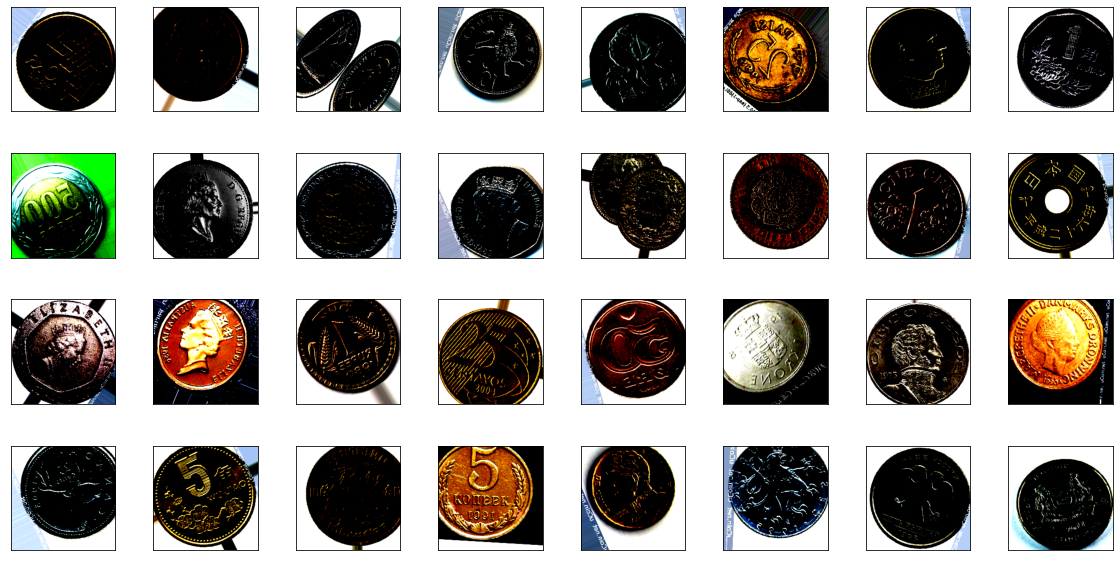

In [43]:
import matplotlib.pyplot as plt


# Lets have a look at some of our images
images, labels = train_generator.next()

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(wspace=0.2, hspace=0.4)

# Lets show the first 32 images of a batch
for i, img in enumerate(images[:32]):
    ax = fig.add_subplot(4, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(img)
    image_idx = np.argmax(labels[i])

In [44]:
int_to_dir = {v: k for k, v in train_generator.class_indices.items()}

In [45]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from keras.applications import ResNet50
from keras.models import Model



base_model = ResNet50(
    include_top=False,
    weights="imagenet"
)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='elu')(x)
x = Dropout(0.95)(x)
# and a logistic layer
predictions = Dense(211, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = True

94765736/94765736 [==============================] - 2s 0us/step


In [46]:
from keras.optimizers import Adam

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy',
             metrics=['accuracy'])

c:\Users\User\anaconda3\envs\sklearn1.1\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

num_train = len(train_generator.filenames)
num_valid = len(valid_generator.filenames)
num_test = len(train_generator.filenames)


# When to save the model
checkpointer = ModelCheckpoint(filepath='model.weights.best.hdf5', verbose=1, 
                               save_best_only=True)

# Reduce learning rate when loss doesn't improve after n epochs
scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=5, min_lr=1e-8, verbose=1)

# Stop early if model doesn't improve after n epochs
early_stopper = EarlyStopping(monitor='val_loss', patience=10,
                              verbose=0, restore_best_weights=True)

# Train the model
history = model.fit_generator(train_generator,
                    steps_per_epoch=num_train//batch_size,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpointer, scheduler, early_stopper],
                    validation_data=valid_generator,
                    validation_steps=num_valid//batch_size)